In [24]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [25]:
%cd '/content/drive/MyDrive/Dataset/'

/content/drive/MyDrive/Dataset


Loading the data and defining some path constants

In [26]:
# Input Directories

data_input_path = os.getcwd()
ct_scan_input = 'ct_scans/'
inf_mask_input = 'infection_mask/'
lung_inf_mask_input = 'lung_and_infection_mask/'
lung_mask_input = 'lung_mask/'

if not os.path.exists('dataset_prep'):
    os.mkdir('dataset_prep')
    print("Directory " , 'dataset_prep' ,  " Created ")
else:    
    print("Directory " , 'dataset_prep' ,  " already exists")

Directory  dataset_prep  already exists


In [36]:
# Slice Output Directories

data_output_path = 'dataset_prep/'

#  CT_scans
if not os.path.exists(os.path.join(data_output_path, 'ct_scans')):
    os.mkdir(os.path.join(data_output_path, 'ct_scans'))
    print("Directory " , os.path.join(data_output_path, 'ct_scans') ,  " Created ")
else:    
    print("Directory " , os.path.join(data_output_path, 'ct_scans') ,  " already exists")

# Infection Mask
if not os.path.exists(os.path.join(data_output_path, 'infection_mask')):
    os.mkdir(os.path.join(data_output_path, 'infection_mask'))
    print("Directory " , os.path.join(data_output_path, 'infection_mask') ,  " Created ")
else:    
    print("Directory " , os.path.join(data_output_path, 'infection_mask') ,  " already exists")

# Lung and Infection Mask
if not os.path.exists(os.path.join(data_output_path, 'lung_and_infection_mask')):
    os.mkdir(os.path.join(data_output_path, 'lung_and_infection_mask'))
    print("Directory " , os.path.join(data_output_path, 'lung_and_infection_mask') ,  " Created ")
else:    
    print("Directory " , os.path.join(data_output_path, 'lung_and_infection_mask') ,  " already exists")

# Lung Mask
if not os.path.exists(os.path.join(data_output_path, 'lung_mask')):
    os.mkdir(os.path.join(data_output_path, 'lung_mask'))
    print("Directory " , os.path.join(data_output_path, 'lung_mask') ,  " Created ")
else:    
    print("Directory " , os.path.join(data_output_path, 'lung_mask') ,  " already exists")

# Output path variables
ct_scan_output = os.path.join(data_output_path, 'ct_scans/')
inf_mask_output = os.path.join(data_output_path, 'infection_mask/')
lung_inf_mask_output = os.path.join(data_output_path, 'lung_and_infection_mask/')
lung_mask_output = os.path.join(data_output_path, 'lung_mask/')

Directory  dataset_prep/ct_scans  already exists
Directory  dataset_prep/infection_mask  already exists
Directory  dataset_prep/lung_and_infection_mask  already exists
Directory  dataset_prep/lung_mask  already exists


Setting up the max and min Hounsfield values for normalization

In [ ]:
# Load image and see max min Hounsfield units

imgPath = os.path.join(ct_scan_input, 'coronacases_org_001.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(-1021.0, 2996.0, (512, 512, 301), numpy.memmap)

In [ ]:
# Load mask and see max min Hounsfield units

imgSlice = os.path.join(inf_mask_input, 'coronacases_001.nii')
mask = nib.load(imgSlice).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (512, 512, 301), numpy.memmap)

In [29]:
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2500
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

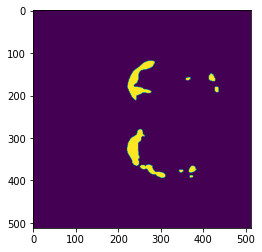

In [ ]:
# Show image slice

imgSlice = mask[:,:,150]
plt.imshow(imgSlice)
plt.show()

In [30]:
# Slicing

SLICE_X = True
SLICE_Y = True
SLICE_Z = False

SLICE_DECIMATE_IDENTIFIER = 3

Read and normalization functions

In [31]:
# Normalization function
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

In [32]:
# Read image or mask volume
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img

In [33]:
# Save volume slice to file
def saveSlice(img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')

In [34]:
# Slice image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [ ]:
# CT Scans file save

for index, filename in enumerate(sorted(glob.iglob(ct_scan_input + '*.nii'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'ct_scan'+str(index), ct_scan_output)
    print(f'\n{filename}, {numOfSlices} slices created \n')

In [ ]:
# Infection Mask file save

for index, filename in enumerate(sorted(glob.iglob(inf_mask_input + '*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'inf_mask'+str(index), inf_mask_output)
    print(f'\n{filename}, {numOfSlices} slices created \n')

In [ ]:
# Lung and Infection Mask file save

for index, filename in enumerate(sorted(glob.iglob(lung_inf_mask_input + '*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'lung_inf_mask'+str(index), lung_inf_mask_output)
    print(f'\n{filename}, {numOfSlices} slices created \n')

In [ ]:
# Lung Mask file save

for index, filename in enumerate(sorted(glob.iglob(lung_mask_input + '*.nii'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'lung_mask'+str(index), lung_mask_output)
    print(f'\n{filename}, {numOfSlices} slices created \n')